# Project : GDP and Life Expectancy
by Shubham Tiwari

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2019 and the life expectancy of people born in that country in 2019.

# Getting the data

Two datasets of the World Bank are considered. One dataset, available at http://data.worldbank.org/indicator/NY.GDP.MKTP.CD, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows us to compare GDP values across countries. The other dataset, available at http://data.worldbank.org/indicator/SP.DYN.LE00.IN, lists the life expectancy of the world's countries. 

In [1]:
from pandas import *
import pandas as pd
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
pd.core.common.is_list_like = api.types.is_list_like

from pandas_datareader.wb import download


In [3]:
YEAR = 2019
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
data = download(indicator=GDP_INDICATOR, country='all',start=YEAR, end=YEAR)

In [4]:
data.head()

,,NY.GDP.MKTP.CD
country,year,
Africa Eastern and Southern,2019,1.001017e+12
Africa Western and Central,2019,7.947191e+11
Arab World,2019,2.818502e+12
Caribbean small states,2019,7.742842e+10
Central Europe and the Baltics,2019,1.675084e+12


The dataframe's index is given by the country and year instead of integers. So, we have to reset the index.

In [5]:
gdp = data.reset_index()

gdp.head()

,country,year,NY.GDP.MKTP.CD
0,Africa Eastern and Southern,2019,1.001017e+12
1,Africa Western and Central,2019,7.947191e+11
2,Arab World,2019,2.818502e+12
3,Caribbean small states,2019,7.742842e+10
4,Central Europe and the Baltics,2019,1.675084e+12


Now let's download the Life Expectancy data of year 2019 and reset the index.

In [6]:
LIFE_INDICATOR = 'SP.DYN.LE00.IN'
data = download(indicator=LIFE_INDICATOR, country='all',start=YEAR, end=YEAR)
life = data.reset_index()
life.head()

,country,year,SP.DYN.LE00.IN
0,Africa Eastern and Southern,2019,63.755674
1,Africa Western and Central,2019,57.555796
2,Arab World,2019,71.844626
3,Caribbean small states,2019,72.519498
4,Central Europe and the Baltics,2019,77.266845


# Cleaning up

The first rows of World Bank dataframes are aggregated data for country groups, and are thus discarded. There were 49 country groups when I generated the data, but the World Bank sometimes adds or removes groups. Therefore, if you obtained the data directly from the World Bank, you may need to discard more or fewer than 49 rows to get a dataframe that starts with Afghanistan.

In [7]:
gdp = gdp[49:]
gdp.head()

,country,year,NY.GDP.MKTP.CD
49,Afghanistan,2019,1.890449e+10
50,Albania,2019,1.540183e+10
51,Algeria,2019,1.717674e+11
52,American Samoa,2019,6.470000e+08
53,Andorra,2019,3.155065e+09


In [8]:
life = life[49:]
life.head()

,country,year,SP.DYN.LE00.IN
49,Afghanistan,2019,63.565
50,Albania,2019,79.282
51,Algeria,2019,76.474
52,American Samoa,2019,NaN
53,Andorra,2019,NaN


There are some NaN values. So, using dropna method to drop them.

In [9]:
gdp = gdp.dropna()
life = life.dropna()

In [10]:
gdp.head()

,country,year,NY.GDP.MKTP.CD
49,Afghanistan,2019,1.890449e+10
50,Albania,2019,1.540183e+10
51,Algeria,2019,1.717674e+11
52,American Samoa,2019,6.470000e+08
53,Andorra,2019,3.155065e+09


# Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of Indian Rupee with the following auxiliary functions, using the average 2019 dollar-to-inr conversion rate provided by http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates.

In [11]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToINR (usd):
    return usd * 70.406

GDP = 'GDP (₹m)'
gdp[GDP] = gdp[GDP_INDICATOR].apply(usdToINR).apply(roundToMillions)
gdp.head()

,country,year,NY.GDP.MKTP.CD,GDP (₹m)
49,Afghanistan,2019,1.890449e+10,1330990
50,Albania,2019,1.540183e+10,1084381
51,Algeria,2019,1.717674e+11,12093456
52,American Samoa,2019,6.470000e+08,45553
53,Andorra,2019,3.155065e+09,222136


The year column is discarded.

In [12]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdp = gdp[headings]
gdp.head()

,country,GDP (₹m)
49,Afghanistan,1330990
50,Albania,1084381
51,Algeria,12093456
52,American Samoa,45553
53,Andorra,222136


The World Bank reports the life expectancy with several decimal places. After rounding them, the original column is discarded.

In [13]:
LIFE = 'Life expectancy (years)'
life[LIFE] = life[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
life = life[headings]
life.head()

,country,Life expectancy (years)
49,Afghanistan,64
50,Albania,79
51,Algeria,76
54,Angola,62
55,Antigua and Barbuda,79


# Combining the data
The tables are combined through an inner join on the common 'country' column.

In [14]:
gdpVsLife = merge(gdp, life, on=COUNTRY, how='inner')
gdpVsLife.head()

,country,GDP (₹m),Life expectancy (years)
0,Afghanistan,1330990,64
1,Albania,1084381,79
2,Algeria,12093456,76
3,Angola,4879777,62
4,Antigua and Barbuda,118812,79


# Calculating the correlation
To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [15]:
from scipy.stats import spearmanr

gdpColumn = gdpVsLife[GDP]
lifeColumn = gdpVsLife[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.45267275135670765
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not very strong.

# Showing the data
Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) rupees.

<AxesSubplot:xlabel='GDP (₹m)', ylabel='Life expectancy (years)'>

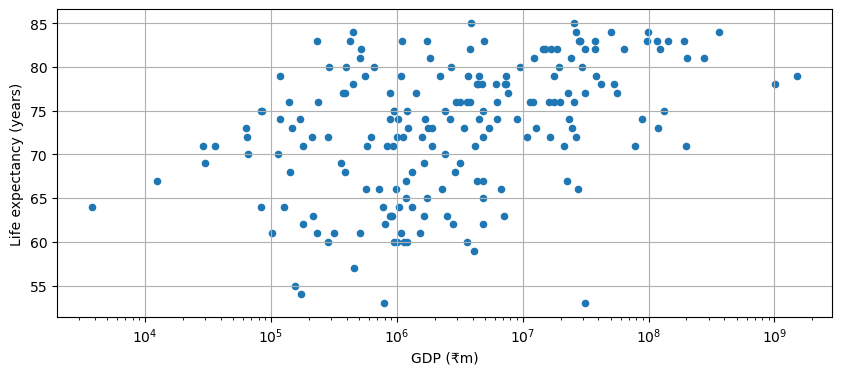

In [16]:
%matplotlib inline
gdpVsLife.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with low life expectancy, poor countries with high life expectancy, and countries with around 100 thousand (10<sup>5</sup>) million rupees GDP have almost the full range of values, from below 50 to over 80 years. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>5</sup>), most countries have an expectancy of 70 years or more, whilst below that threshold most countries' life expectancy is below 70 years.

Comparing the 10 poorest countries and the 10 countries with the lowest life expectancy shows that total GDP is a rather crude measure. The population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. Furthermore, looking at the countries below, droughts and internal conflicts may also play a role in life expectancy.

The 10 countries with lowest GDP and 10 countries with lowest life Expectancy.


In [17]:
gdpVsLife.sort_values(GDP).head(10)

,country,GDP (₹m),Life expectancy (years)
181,Tuvalu,3818,64
93,Kiribati,12528,67
117,"Micronesia, Fed. Sts.",29007,71
149,Sao Tome and Principe,30093,69
175,Tonga,36052,71
164,St. Vincent and the Grenadines,64080,73
148,Samoa,64277,72
189,Vanuatu,65937,70
38,Comoros,84137,64
180,Turks and Caicos Islands,84305,75


In [18]:
gdpVsLife.sort_values(LIFE).head(10)

,country,GDP (₹m),Life expectancy (years)
131,Nigeria,31550338,53
34,Chad,796640,53
101,Lesotho,172775,54
33,Central African Republic,156393,55
159,Somalia,456583,57
42,Cote d'Ivoire,4121527,59
39,"Congo, Dem. Rep.",3645329,60
27,Burkina Faso,1139040,60
154,Sierra Leone,287016,60
72,Guinea,946458,60


They don't coincide when the GDP and Life Expectancy are low. Let's see if the ten countries with the highest GDP coincide with the ten countries with the longest life expectancy

In [19]:
gdpVsLife.sort_values(GDP).tail(10)

,country,GDP (₹m),Life expectancy (years)
32,Canada,122648311,82
24,Brazil,131889760,75
87,Italy,141607743,83
60,France,192128839,83
80,India,199358266,71
185,United Kingdom,201154015,81
65,Germany,273754442,81
89,Japan,360712338,84
36,China,1005393280,78
186,United States,1505349005,79


In [20]:
gdpVsLife.sort_values(LIFE).tail(10)

,country,GDP (₹m),Life expectancy (years)
113,Malta,1107194,83
8,Australia,98021195,83
167,Sweden,37588322,83
161,Spain,98168498,84
89,Japan,360712338,84
168,Switzerland,50788714,84
104,Liechtenstein,452517,84
155,Singapore,26435533,84
107,"Macao SAR, China",3886746,85
77,"Hong Kong SAR, China",25561074,85


Only one Country coincide with highest life expectancy and highest GDP.

# Conclusions

To sum up, there is no strong correlation between a country's wealth and the life expectancy of its inhabitants: there is often a wide variation of life expectancy for countries with similar GDP, countries with the lowest life expectancy are not the poorest countries, and countries with the highest expectancy are not the richest countries. Nevertheless there is some relationship, because the vast majority of countries with a life expectancy below 70 years is on the left half of the scatterplot.

Using the NY.GDP.PCAP.PP.CD indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.